In [84]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import combinations
from skimage import color, exposure
from skimage.feature import hog


from skimage.color import rgb2gray
from sklearn.cluster import KMeans
from skimage.feature import graycomatrix, graycoprops

from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [85]:
def read_data(data_path, data_type):
    """
    Read data from specified data path based on the data type.

    Args:
    - data_path (str): The path to the data directory.
    - data_type (str): Type of data to read ('before', 'after', or 'label').

    Returns:
    - data (list): A list containing the loaded images.
    """

    if data_type == 'before':
        data_path = os.path.join(data_path, 'A')
    elif data_type == 'after':
        data_path = os.path.join(data_path, 'B')
    elif data_type == 'label':
        data_path = os.path.join(data_path, 'label')
    else:
        print('data_type is not correct')
        return None

    data = []
    for file in os.listdir(data_path):
        img = cv2.imread(os.path.join(data_path, file))
        data.append(img)
    return data

In [86]:
def display_images(before, after, labels):
    """
    Display images of 'before', 'after', and 'labels' side by side.

    Args:
    - before (numpy.ndarray): Image data for 'before'.
    - after (numpy.ndarray): Image data for 'after'.
    - labels (numpy.ndarray): Image data for 'labels'.
    """

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(cv2.cvtColor(before, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Before')
    axs[0].axis('off')
    axs[1].imshow(cv2.cvtColor(after, cv2.COLOR_BGR2RGB))
    axs[1].set_title('After')
    axs[1].axis('off')
    axs[2].imshow(labels, cmap='gray')
    axs[2].set_title('Labels')
    axs[2].axis('off')
    plt.show()


In [87]:
def plot_row(images, titles):
    """
    Plot a row of images with corresponding titles.

    Args:
    - images (list): List of numpy arrays representing images.
    - titles (list): List of titles corresponding to each image.
    """

    fig, ax = plt.subplots(1, len(images), figsize=(10, 20))
    ax[0].imshow(images[0].astype("uint8"))
    ax[0].set_title(titles[0])
    ax[0].axis("off")
    for i in range(len(images) - 1):
        ax[i+1].imshow(images[i + 1])
        ax[i+1].set_title(titles[i + 1])
        ax[i+1].axis("off")
    plt.tight_layout()
    plt.show()


In [88]:
training_path = 'trainval/'

In [89]:
before_images = read_data(training_path,'before')
after_images = read_data(training_path, 'after')
labels = read_data(training_path,'label')

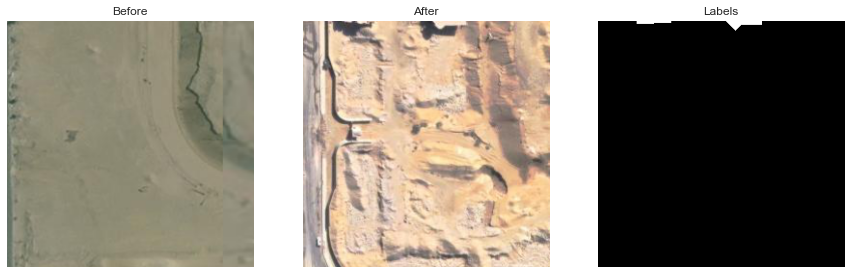

In [90]:
index = 0
# print first image in before_images, after_images, and labels in the same row
display_images(before_images[index], after_images[index], labels[index])

In [125]:
# Perform preprocessing steps for each image
preprocessed_images_A = []
preprocessed_images_B = []

# Image Enhancement (Contrast Stretching) parameters
clahe_clip_limit = 2.0
clahe_tile_grid_size = (8, 8)
clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=clahe_tile_grid_size)

# Normalization parameters
norm_alpha = 0
norm_beta = 255
"""
1. CLAHE Enhancement: Apply Contrast Limited Adaptive Histogram Equalization (CLAHE) to enhance the contrast of images.
2. Normalization: Normalize the intensity range of images.
3. Gaussian Blur Parameters Definition: Define parameters for Gaussian Blur, which is used for noise reduction.
4. Gaussian Blur: Apply Gaussian Blur to reduce noise in the images.
5. Appending Preprocessed Images: Append the preprocessed images to the respective lists for dataset A and B.
"""
for image_A, image_B in zip(before_images, after_images):
    # Image Enhancement (Contrast Stretching)
    enhanced_image_A = clahe.apply(image_A[:,:,0])  
    enhanced_image_B = clahe.apply(image_B[:,:,0])

    # Normalization
    normalized_image_A = cv2.normalize(enhanced_image_A, None, alpha=norm_alpha, beta=norm_beta, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    normalized_image_B = cv2.normalize(enhanced_image_B, None, alpha=norm_alpha, beta=norm_beta, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Noise Reduction (Gaussian Blur) parameters
    blur_kernel_size = (5, 5)
    blur_sigma = 0

    # Noise Reduction (Gaussian Blur)
    blurred_image_A = cv2.GaussianBlur(normalized_image_A, blur_kernel_size, blur_sigma)
    blurred_image_B = cv2.GaussianBlur(normalized_image_B, blur_kernel_size, blur_sigma)

    # Append preprocessed images to the list
    preprocessed_images_A.append(blurred_image_A)
    preprocessed_images_B.append(blurred_image_B)


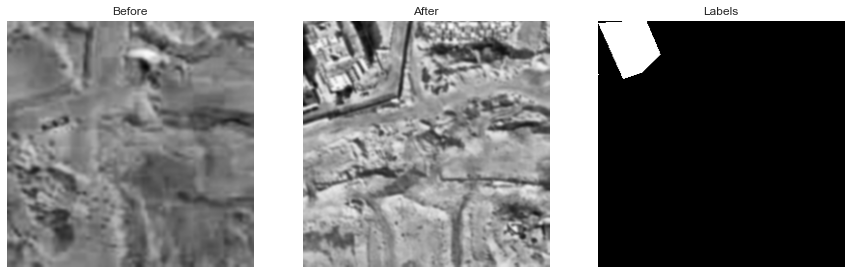

In [126]:
index = 1
# plot the first preprocessed image
display_images(preprocessed_images_A[index], preprocessed_images_B[index], labels[index])


In [127]:
def preprocess_images(before_images, after_images, gamma_values):
    """
    Preprocesses a list of before and after satellite images using gamma correction.

    Args:
    - before_images: List of NumPy arrays representing the before images (RGB).
    - after_images: List of NumPy arrays representing the after images (RGB).
    - gamma_values: List of gamma values to apply for gamma correction.

    Returns:
    - preprocessed_images_A: List of preprocessed before images.
    - preprocessed_images_B: List of preprocessed after images.
    """
    preprocessed_images_A = []
    preprocessed_images_B = []

    for gamma in gamma_values:
        for image_A, image_B in zip(before_images, after_images):

            # Gamma Correction
            corrected_image_A = exposure.adjust_gamma(image_A, gamma)
            corrected_image_B = exposure.adjust_gamma(image_B, gamma)
            
            # Append preprocessed images to the list
            preprocessed_images_A.append(corrected_image_A)
            preprocessed_images_B.append(corrected_image_B)

    return preprocessed_images_A, preprocessed_images_B


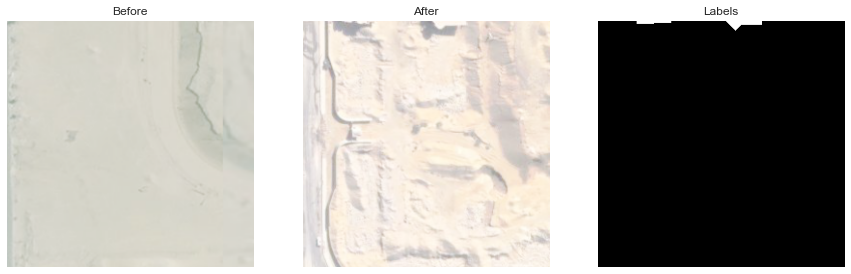

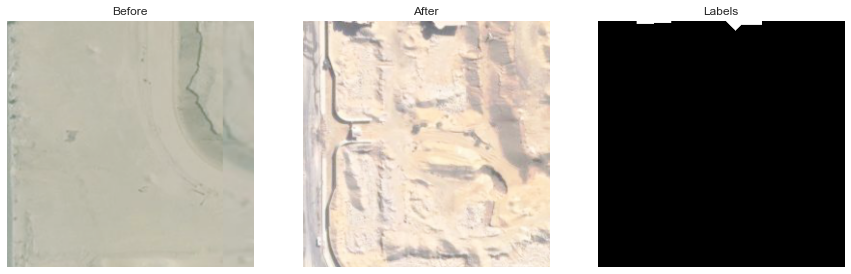

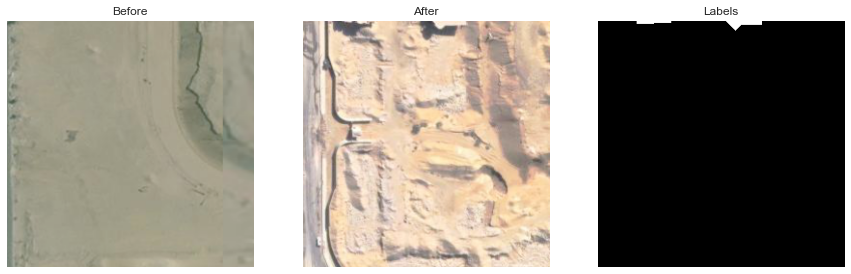

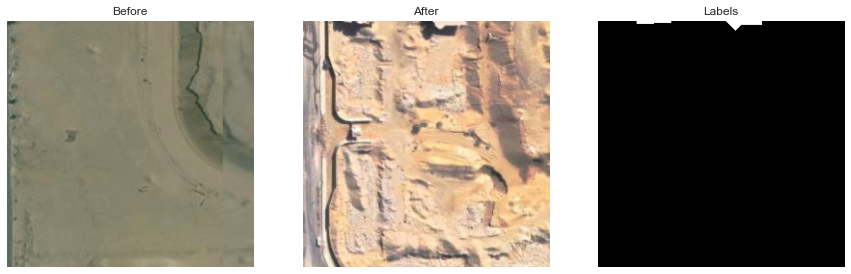

In [128]:
"""
Gamma correction reasons:
- Non-linear Sensitivity of Imaging Devices: 
1-  Imaging devices, including satellite sensors, often have a non-linear sensitivity to light. 
    Gamma correction helps in compensating for this non-linearity, ensuring that the displayed image has an appropriate brightness and contrast representation.

2-  Enhancing Image Contrast: 
    Gamma correction can enhance the contrast of satellite images by adjusting the pixel intensities. 
    This adjustment helps in bringing out details in both darker and lighter regions of the image, which might otherwise be lost.

3-  Improving Visualization: 
    Gamma correction can improve the visualization of satellite images.
    By adjusting the brightness and contrast levels, gamma correction can highlight features of interest in the image.
"""
# Example usage
gamma_values = [0.3, 0.5, 0.8, 1.1]  # Gamma values to apply

# take first image in before_images and after_images
before_images2 = before_images[:1]
after_images2 = after_images[:1]

preprocessed_images_A, preprocessed_images_B = preprocess_images(before_images2, after_images2, gamma_values)

# Display the first preprocessed image for each gamma value
for i, gamma in enumerate(gamma_values):
    display_images(preprocessed_images_A[i], preprocessed_images_B[i], labels[0])


In [129]:
def increase_saturation(before_images, after_images, factor):
    """
    Increases the saturation of an image using the HSV color space.

    Args:
    - image: NumPy array representing the image (RGB).
    - factor: Factor to increase the saturation by.

    Returns:
    - image: NumPy array representing the image with increased saturation (RGB).
    """
    preprocessed_images_A = []
    preprocessed_images_B = []

    for image_A, image_B in zip(before_images, after_images):
        # Convert the image to the HSV color space
        hsv_image_A = color.rgb2hsv(image_A)
        hsv_image_B = color.rgb2hsv(image_B)

        # Increase the saturation
        hsv_image_A[:, :, 1] *= factor
        hsv_image_B[:, :, 1] *= factor

        # convert to RGB
        enhanced_image_A = color.hsv2rgb(hsv_image_A)
        enhanced_image_B = color.hsv2rgb(hsv_image_B)

        # multiply by 255
        enhanced_image_A = (enhanced_image_A * 255).astype(np.uint8)
        enhanced_image_B = (enhanced_image_B * 255).astype(np.uint8)

        # Append preprocessed images to the list
        preprocessed_images_A.append(enhanced_image_A)
        preprocessed_images_B.append(enhanced_image_B)

    return preprocessed_images_A, preprocessed_images_B

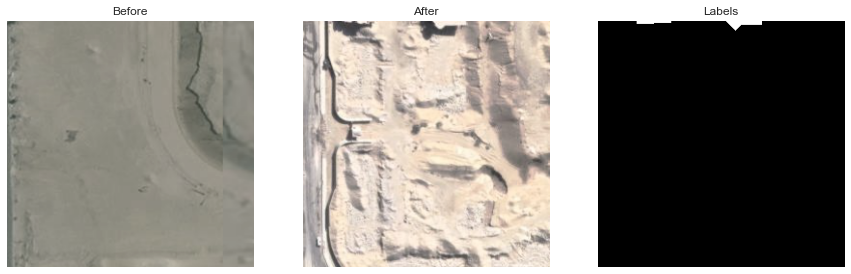

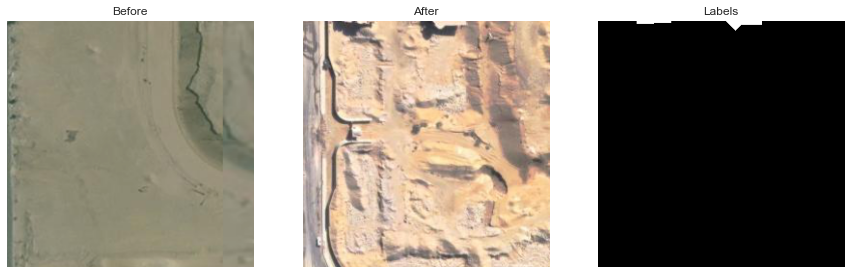

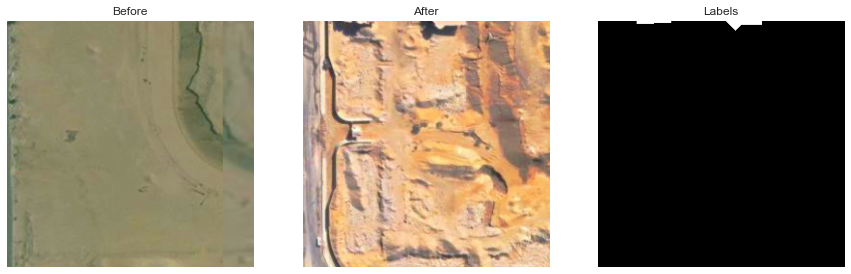

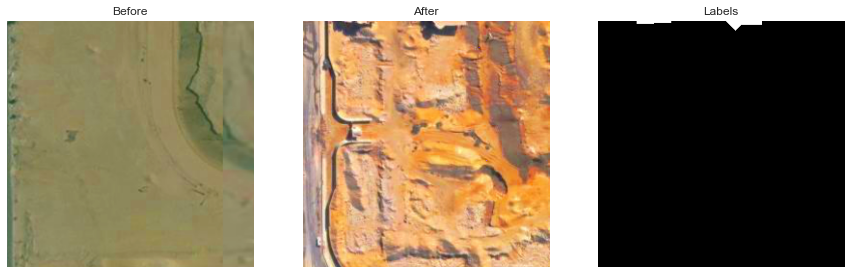

In [130]:
"""
Increasing saturation reasons:

1-  Enhanced Feature Discrimination: 
    Saturation enhancement can help distinguish between different features in the satellite image.

2-  Improved Visualization.
    
3-  Highlighting Specific Features: 
    Saturation enhancement can be used to highlight specific features or areas of interest in the satellite image. 

4-  Improved Image Quality: 
    In some cases, satellite images may appear dull or washed out due to factors such as sensor limitations or processing techniques. 
    Increasing saturation can help enhance the overall quality and aesthetic appeal of the image, making it more suitable for presentation or publication purposes.
"""

# test the function
factor = [0.5, 1.0, 1.5, 2.0]  

before_images2 = before_images[:1]
after_images2 = after_images[:1]

for f in factor:
    preprocessed_images_A, preprocessed_images_B = increase_saturation(before_images2, after_images2, f)
    display_images(preprocessed_images_A[0], preprocessed_images_B[0], labels[0])


## Colors Features

In [131]:
# get colors distribution for each class

class_A = before_images
class_B = after_images
class_labels = labels

class_A_colors = []
for image in class_A:
    class_A_colors.append(np.mean(image, axis=(0, 1)))
class_A_colors = np.array(class_A_colors)

class_B_colors = []
for image in class_B:
    class_B_colors.append(np.mean(image, axis=(0, 1)))
class_B_colors = np.array(class_B_colors)


In [132]:
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

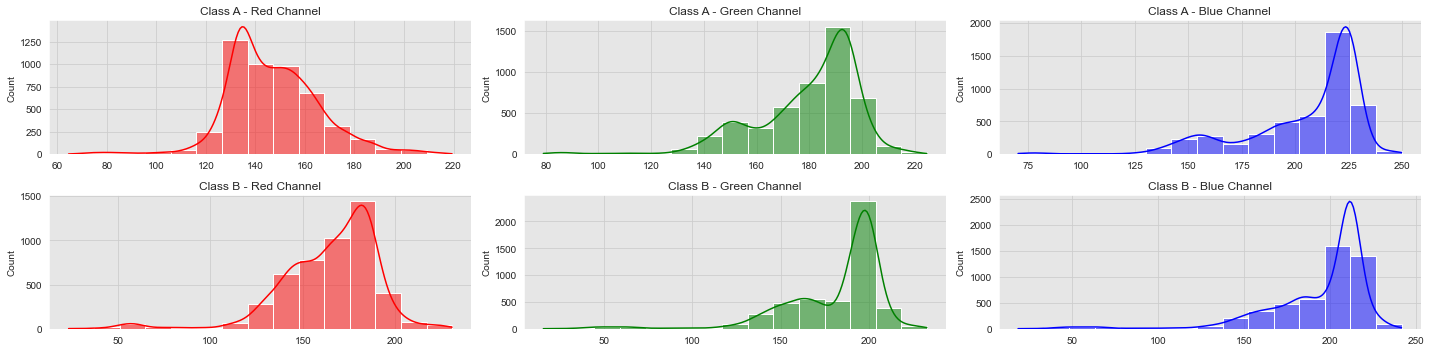

In [133]:
"""
Analyzing the RGB color distribution for each class (change and no-change):

1-  Discriminative Power: 
    Differences in RGB color distributions between change and no-change areas can be indicative of underlying changes in the landscape. 
    For example, changes in land cover types may be associated with shifts in color distributions due to differences in vegetation, soil, or built structures. 
    By analyzing these differences, you can identify discriminative features that help distinguish between change and no-change areas.

3. **Visualization**: Visualizing the RGB color distributions can provide intuitive insights into the nature of changes occurring in the satellite images. By plotting histograms or density plots of pixel intensities for each class, you can visually inspect how the distribution of colors varies between change and no-change areas. This can help identify any distinct clusters or patterns that may exist within the data.

4. **Data Exploration**: Analyzing the RGB color distributions can help you gain a better understanding of the data and identify any potential challenges or biases that may exist in the classification task. For example, you may discover that certain regions exhibit highly variable color distributions, making them more difficult to classify accurately. By uncovering such insights, you can develop more effective strategies for handling these challenges.

Overall, analyzing the RGB color distributions for change and no-change classes in satellite images can provide valuable information that can improve the accuracy and interpretability of classification models. By leveraging these insights, you can develop more robust and reliable methods for monitoring changes in the landscape using satellite imagery.

"""

bins = 15
fig, ax = plt.subplots(2, 3, figsize=(20, 5))
sns.histplot(class_A_colors[:, 0], bins=bins, ax=ax[0, 0], color='red', kde=True)
sns.histplot(class_A_colors[:, 1], bins=bins, ax=ax[0, 1], color='green', kde=True)
sns.histplot(class_A_colors[:, 2], bins=bins, ax=ax[0, 2], color='blue', kde=True)

sns.histplot(class_B_colors[:, 0], bins=bins, ax=ax[1, 0], color='red', kde=True)
sns.histplot(class_B_colors[:, 1], bins=bins, ax=ax[1, 1], color='green', kde=True)
sns.histplot(class_B_colors[:, 2], bins=bins, ax=ax[1, 2], color='blue', kde=True)

ax[0, 0].set_title('Class A - Red Channel')
ax[0, 1].set_title('Class A - Green Channel')
ax[0, 2].set_title('Class A - Blue Channel')

ax[1, 0].set_title('Class B - Red Channel')
ax[1, 1].set_title('Class B - Green Channel')
ax[1, 2].set_title('Class B - Blue Channel')

plt.tight_layout()
plt.show()


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12824\3246286981.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], ax=ax[i], ci='sd')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12824\3246286981.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], ax=ax[i], ci='sd')
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_12824\3246286981.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], ax=ax[i], ci='sd')


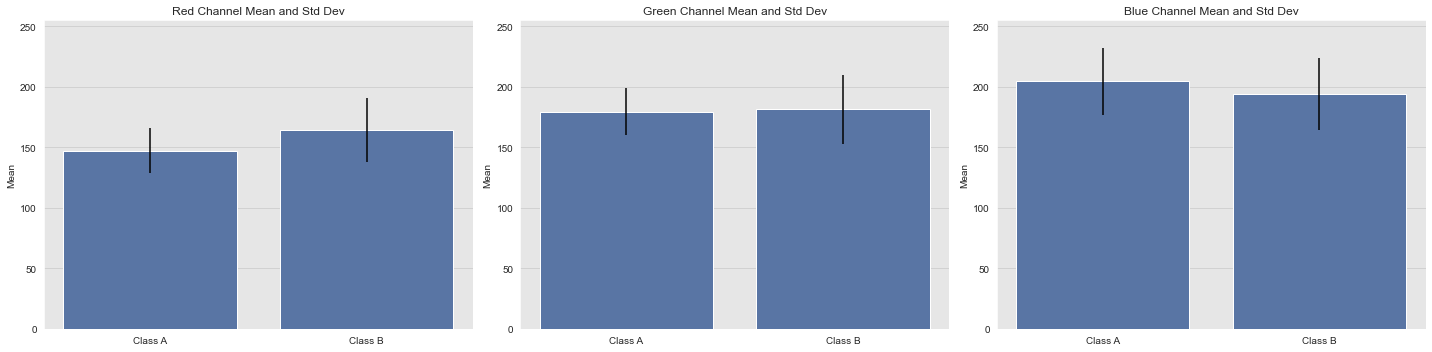

In [134]:
# Calculate mean and standard deviation for each color channel
class_A_mean = np.mean(class_A_colors, axis=0)
class_A_std = np.std(class_A_colors, axis=0)

class_B_mean = np.mean(class_B_colors, axis=0)
class_B_std = np.std(class_B_colors, axis=0)

# Plotting
channels = ['Red', 'Green', 'Blue']
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, channel in enumerate(channels):
    sns.barplot(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], ax=ax[i], ci='sd')
    ax[i].errorbar(x=['Class A', 'Class B'], y=[class_A_mean[i], class_B_mean[i]], yerr=[class_A_std[i], class_B_std[i]], fmt='none', color='black')

    ax[i].set_title(f'{channel} Channel Mean and Std Dev')
    ax[i].set_ylabel('Mean')
    ax[i].set_ylim(0, 255)

plt.tight_layout()
plt.show()


In [135]:
before_images = np.array(before_images)
after_images = np.array(after_images)
labels = np.array(labels)

In [136]:
# Calculate histogram differences for training images
X_train_hist_diff = []
Y_train_hist_diff = []

for image_A, image_B, label in zip(before_images, after_images, labels):

    # compute the histograms for the RGB channels
    hist_A_red = cv2.calcHist([image_A], [0], None, [256], [0, 256])
    hist_A_green = cv2.calcHist([image_A], [1], None, [256], [0, 256])
    hist_A_blue = cv2.calcHist([image_A], [2], None, [256], [0, 256])

    hist_B_red = cv2.calcHist([image_B], [0], None, [256], [0, 256])
    hist_B_green = cv2.calcHist([image_B], [1], None, [256], [0, 256])
    hist_B_blue = cv2.calcHist([image_B], [2], None, [256], [0, 256])

    # normalize the histograms
    hist_A_red = hist_A_red / np.sum(hist_A_red)
    hist_A_green = hist_A_green / np.sum(hist_A_green)
    hist_A_blue = hist_A_blue / np.sum(hist_A_blue)

    hist_B_red = hist_B_red / np.sum(hist_B_red)
    hist_B_green = hist_B_green / np.sum(hist_B_green)
    hist_B_blue = hist_B_blue / np.sum(hist_B_blue)
    
    # compute the histogram differences
    hist_diff_red = np.abs(hist_A_red - hist_B_red)
    hist_diff_green = np.abs(hist_A_green - hist_B_green)
    hist_diff_blue = np.abs(hist_A_blue - hist_B_blue)

    # take the mean of the histogram differences
    hist_mean = np.array([np.mean(hist_diff_red), np.mean(hist_diff_green), np.mean(hist_diff_blue)])
        
    # append the histogram difference to the list
    X_train_hist_diff.append(hist_mean)

    # take the mean of all channels of the label image so that the result is a scalar
    Y_train_hist_diff.append(np.mean(label))
    

# Convert lists to NumPy arrays
X_train_hist_diff = np.array(X_train_hist_diff)
Y_train_hist_diff = np.array(Y_train_hist_diff)



In [137]:
print(X_train_hist_diff.shape)
print(Y_train_hist_diff.shape)
print(Y_train_hist_diff[0])

(4868, 3)
(4868,)
1.330718994140625


In [138]:
print(X_train_hist_diff[0])

[0.0065099  0.00634289 0.00681102]


In [139]:
# convert y_train_hist_diff to binary so that it can be used for classification
threshold = 10
Y_train_hist_diff_binary = (Y_train_hist_diff > threshold).astype(int)


In [140]:
print(Y_train_hist_diff_binary[:10])

[0 0 1 0 0 0 0 0 0 0]


In [210]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_hist_diff, Y_train_hist_diff_binary, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate Jaccard Index for training data and test data
jaccard_train = jaccard_score(y_train, rf_classifier.predict(X_train))
jaccard_test = jaccard_score(y_test, y_pred)

print(f'Jaccard Index (Training): {jaccard_train:.2f}')
print(f'Jaccard Index (Test): {jaccard_test:.2f}')


Accuracy: 0.82
F1 Score: 0.69
Jaccard Index (Training): 0.73
Jaccard Index (Test): 0.53


In [143]:
# Initialize and train SVC classifier
svc_classifier = SVC(C=100)
svc_classifier.fit(X_train, y_train)

# Make predictions
y_pred = svc_classifier.predict(X_test)

# Calculate Jaccard Index for training data and test data
jaccard_train = jaccard_score(y_train, svc_classifier.predict(X_train))
jaccard_test = jaccard_score(y_test, y_pred)

print(f'Jaccard Index (Training): {jaccard_train:.2f}')
print(f'Jaccard Index (Test): {jaccard_test:.2f}')

Jaccard Index (Training): 0.57
Jaccard Index (Test): 0.52


## HOG

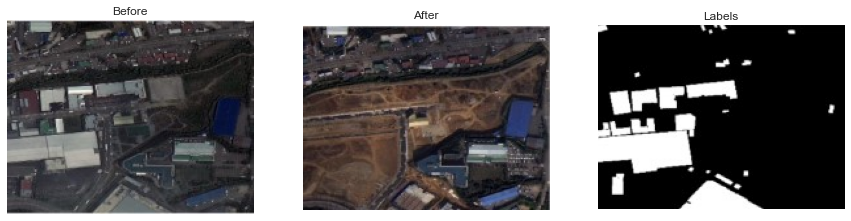

In [159]:
# Load images
image_A = cv2.imread('hog/A1.jpg')
image_B = cv2.imread('hog/B1.jpg')
label = cv2.imread('hog/label1.jpg')

# Convert images to grayscale
gray_A = cv2.cvtColor(image_A, cv2.COLOR_BGR2GRAY)
gray_B = cv2.cvtColor(image_B, cv2.COLOR_BGR2GRAY)

# Resize images to have the same dimensions
resized_gray_A = cv2.resize(gray_A, (gray_B.shape[1], gray_B.shape[0]))
resized_gray_B = cv2.resize(gray_B, (gray_B.shape[1], gray_B.shape[0]))

# Compute HOG features for grayscale images
hog_A, _ = hog(resized_gray_A, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
hog_B, _ = hog(gray_B, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

# Concatenate HOG features into a single array
hog_features = np.concatenate((hog_A.ravel(), hog_B.ravel())).reshape(-1, 1)

# Apply clustering (e.g., K-means clustering)
num_clusters = 2  # Number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(hog_features)

# Predict cluster labels
labels2 = kmeans.labels_

# Display the image_a, image_b, and label side by side using display_images function AFTER HOG AND CLUSTERING
display_images(image_A, image_B, label)


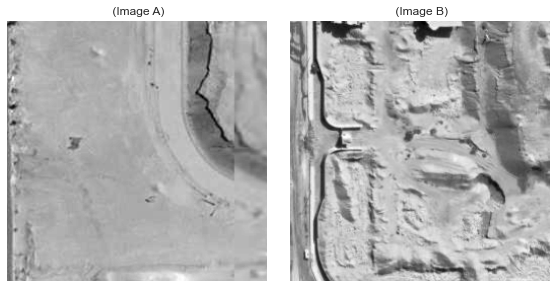

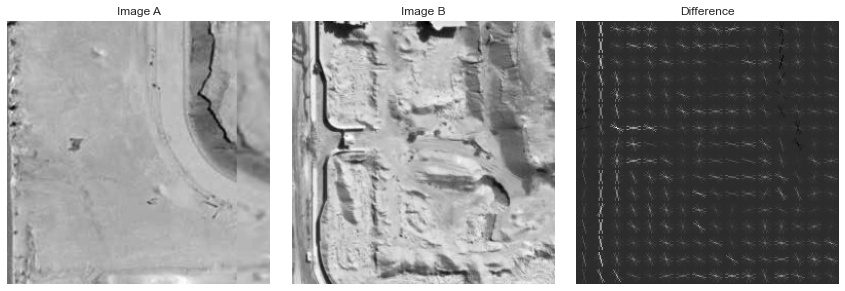

In [168]:
"""
Histogram of Oriented Gradients (HOG):

1-  Texture and Shape Representation: 
    HOG captures the distribution of gradient orientations in an image, 

2-  Rotation Invariance: 
    HOG features are inherently rotationally invariant, 

3-  Efficient Representation: 
    HOG features provide a compact and efficient representation of image content, making them suitable for use in machine learning algorithms. 

HOG function will take the original image as input. 
The image will be divided into blocks of equal size and the blocks will be divided into cells of equal size. 
Then a histogram will be generated for each cell. 
This histogram will contain information about how all the gradients in the cell are oriented according to the number of bins that we specified in the range of 0° — 180°. 
These histograms from all the cells will be added together which will become a long, one-dimensional vector. This vector we get will be the ‘HOG feature vector’ of our image.  

block_norm='L2-Hys' ==> a block normalization method that combines L2-norm normalization with histogram equalization in the spatial domain, 
resulting in robust and discriminative HOG descriptors suitable for tasks such as object detection and image classification.
"""

# Number of clusters for k-means
num_clusters = 5  # You can adjust this number as needed

# Initialize lists to store clustered HOG features and labels
X_train_clustered_hog = []
Y_train_hog = []

before_images2 = before_images[0:1]
after_images2 = after_images[0:1]
labels2 = labels[0:1]

for image_A, image_B, label in zip(before_images2, after_images2, labels2):
    # Ensure images have three channels (RGB)
    if image_A.shape[2] != 3 or image_B.shape[2] != 3:
        raise ValueError("Images must have three channels (RGB).")

    # Convert images to grayscale
    gray_image_A = rgb2gray(image_A)
    gray_image_B = rgb2gray(image_B)

    # Calculate HOG features for the grayscale images
    hog_features_A = hog(gray_image_A, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)[0]
    hog_features_B = hog(gray_image_B, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)[0]

    # Concatenate HOG features
    hog_features = np.concatenate((hog_features_A, hog_features_B))
    
    # Perform k-means clustering on HOG features
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(hog_features.reshape(-1, 1))  # Reshape for clustering
    
    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_.flatten()
    
    # Append the cluster centers to the list
    X_train_clustered_hog.append(cluster_centers)
    
    # Take the mean of all channels of the label image so that the result is a scalar
    Y_train_hog.append(np.mean(label))

# Convert lists to NumPy arrays
X_train_clustered_hog = np.array(X_train_clustered_hog)
Y_train_hog = np.array(Y_train_hog)

import matplotlib.pyplot as plt

# Calculate HOG features for the grayscale images with visualization
hog_features_A, hog_image_A = hog(gray_image_A, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
hog_features_B, hog_image_B = hog(gray_image_B, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

# Display the HOG feature visualizations
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

axes[0].imshow(gray_image_A, cmap='gray')
axes[0].set_title(' (Image A)')
axes[0].axis('off')

axes[1].imshow(gray_image_B, cmap='gray')
axes[1].set_title(' (Image B)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

import matplotlib.pyplot as plt

# Calculate HOG features for the grayscale images with visualization
hog_features_A, hog_image_A = hog(gray_image_A, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
hog_features_B, hog_image_B = hog(gray_image_B, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)

# Calculate the difference between the HOG visualizations
hog_diff = hog_image_A - hog_image_B

# invert the hog_diff image
hog_diff = 255 - hog_diff

# Display the original images and their HOG visualizations
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

axes[0].imshow(gray_image_A, cmap='gray')
axes[0].set_title('Image A')
axes[0].axis('off')

axes[1].imshow(gray_image_B, cmap='gray')
axes[1].set_title('Image B')
axes[1].axis('off')

axes[2].imshow(hog_diff, cmap='gray')
axes[2].set_title('Difference')
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [200]:
"""
Histogram of Oriented Gradients (HOG):

1-  Texture and Shape Representation: 
    HOG captures the distribution of gradient orientations in an image, 

2-  Rotation Invariance: 
    HOG features are inherently rotationally invariant, 

3-  Efficient Representation: 
    HOG features provide a compact and efficient representation of image content, making them suitable for use in machine learning algorithms. 

HOG function will take the original image as input. 
The image will be divided into blocks of equal size and the blocks will be divided into cells of equal size. 
Then a histogram will be generated for each cell. 
This histogram will contain information about how all the gradients in the cell are oriented according to the number of bins that we specified in the range of 0° — 180°. 
These histograms from all the cells will be added together which will become a long, one-dimensional vector. This vector we get will be the ‘HOG feature vector’ of our image.  

block_norm='L2-Hys' ==> a block normalization method that combines L2-norm normalization with histogram equalization in the spatial domain, 
resulting in robust and discriminative HOG descriptors suitable for tasks such as object detection and image classification.
"""

# Number of clusters for k-means
num_clusters = 5  # You can adjust this number as needed

# Initialize lists to store clustered HOG features and labels
X_train_clustered_hog = []
Y_train_hog = []

for image_A, image_B, label in zip(before_images, after_images, labels):
    # Ensure images have three channels (RGB)
    if image_A.shape[2] != 3 or image_B.shape[2] != 3:
        raise ValueError("Images must have three channels (RGB).")

    # Convert images to grayscale
    gray_image_A = rgb2gray(image_A)
    gray_image_B = rgb2gray(image_B)

    # Calculate HOG features for the grayscale images
    hog_features_A = hog(gray_image_A, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)[0]
    hog_features_B = hog(gray_image_B, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)[0]

    # Concatenate HOG features
    hog_features = np.concatenate((hog_features_A, hog_features_B))
    
    # Perform k-means clustering on HOG features
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(hog_features.reshape(-1, 1))  # Reshape for clustering
    
    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_.flatten()
    
    # Append the cluster centers to the list
    X_train_clustered_hog.append(cluster_centers)
    
    # Take the mean of all channels of the label image so that the result is a scalar
    Y_train_hog.append(np.mean(label))

# Convert lists to NumPy arrays
X_train_clustered_hog = np.array(X_train_clustered_hog)
Y_train_hog = np.array(Y_train_hog)



In [199]:
print(X_train_clustered_hog.shape)
print(Y_train_hog.shape)

(1, 5)
(1,)


In [123]:
# convert the y_train_hog to binary so that it can be used for classification
threshold = 10
Y_train_hog_binary = (Y_train_hog > threshold).astype(int)

In [144]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_clustered_hog, Y_train_hog_binary, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate Jaccard Index for training data and test data
jaccard_train = jaccard_score(y_train, rf_classifier.predict(X_train))
jaccard_test = jaccard_score(y_test, y_pred)

print(f'Jaccard Index (Training): {jaccard_train:.2f}')
print(f'Jaccard Index (Test): {jaccard_test:.2f}')


Accuracy: 0.77
F1 Score: 0.55
Jaccard Index (Training): 0.78
Jaccard Index (Test): 0.38


## GLCM

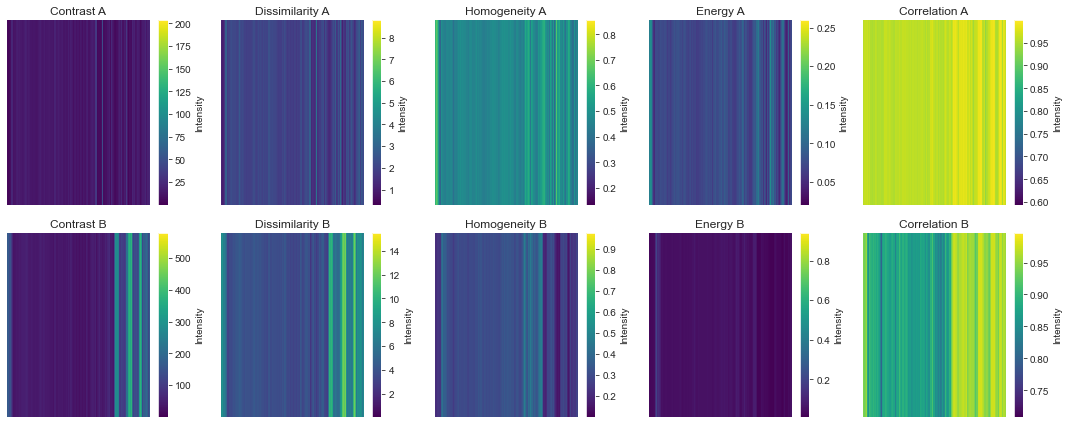

In [173]:
"""
GLCM (Gray-Level Co-occurrence Matrix):

1-  Texture Analysis: 
    GLCM is commonly used for texture analysis in images. 
    In satellite imagery, different land cover types often exhibit distinct textures, which can be captured by GLCM. 
    By computing GLCM features, such as contrast, correlation, energy, and homogeneity, you can characterize the texture properties of different regions in the satellite images.

2-  Spatial Relationships: 
    GLCM captures the spatial relationships between pixel intensities in an image. 
    In satellite imagery, changes in land cover or land use often result in spatially correlated patterns. 
    GLCM can quantify these patterns by analyzing the frequency of occurrence of different pairs of pixel intensities at different spatial offsets. 
    This information can be valuable for distinguishing between different classes in the classification task.

3-  Invariance to Intensity Variations: 
    GLCM features are often invariant to changes in overall image intensity, making them robust to variations in illumination or sensor settings. 
    In satellite imagery, variations in lighting conditions or atmospheric effects can affect the overall brightness of the images. 
    By extracting GLCM features, you can focus on capturing the underlying texture and spatial patterns that are less affected by such variations.
"""
# Calculate GLCM features for training images
X_train_glcm = []
Y_train_glcm = []

for image_A, image_B, label in zip(before_images, after_images, labels):
    # Convert the images to grayscale
    gray_image_A = cv2.cvtColor(image_A, cv2.COLOR_BGR2GRAY)
    gray_image_B = cv2.cvtColor(image_B, cv2.COLOR_BGR2GRAY)
    
    # Calculate the GLCM for the images
    glcm_A = graycomatrix(gray_image_A, [1], [0], 256, symmetric=True, normed=True)
    glcm_B = graycomatrix(gray_image_B, [1], [0], 256, symmetric=True, normed=True)
    
    # Calculate the contrast, dissimilarity, homogeneity, energy, and correlation properties
    contrast_A = graycoprops(glcm_A, 'contrast')
    dissimilarity_A = graycoprops(glcm_A, 'dissimilarity')
    homogeneity_A = graycoprops(glcm_A, 'homogeneity')
    energy_A = graycoprops(glcm_A, 'energy')
    correlation_A = graycoprops(glcm_A, 'correlation')
    
    contrast_B = graycoprops(glcm_B, 'contrast')
    dissimilarity_B = graycoprops(glcm_B, 'dissimilarity')
    homogeneity_B = graycoprops(glcm_B, 'homogeneity')
    energy_B = graycoprops(glcm_B, 'energy')
    correlation_B = graycoprops(glcm_B, 'correlation')
    
    # Take the mean of the GLCM properties
    glcm_mean = np.array([np.mean(contrast_A), np.mean(dissimilarity_A), np.mean(homogeneity_A), np.mean(energy_A), np.mean(correlation_A),
                          np.mean(contrast_B), np.mean(dissimilarity_B), np.mean(homogeneity_B), np.mean(energy_B), np.mean(correlation_B)])
    
    # Append the GLCM features to the list
    X_train_glcm.append(glcm_mean)
    
    # Take the mean of all channels of the label image so that the result is a scalar
    Y_train_glcm.append(np.mean(label))

# Convert lists to NumPy arrays
X_train_glcm = np.array(X_train_glcm)
Y_train_glcm = np.array(Y_train_glcm)

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Plot the GLCM properties
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Reshape the features for plotting
contrast_A, dissimilarity_A, homogeneity_A, energy_A, correlation_A, \
contrast_B, dissimilarity_B, homogeneity_B, energy_B, correlation_B = X_train_glcm.T

# Plot Image A GLCM properties
cax = axes[0, 0].imshow(contrast_A.reshape(1, -1), cmap='viridis', aspect='auto')
axes[0, 0].set_title('Contrast A')
axes[0, 0].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 0])
cbar.set_label('Intensity')

cax = axes[0, 1].imshow(dissimilarity_A.reshape(1, -1), cmap='viridis', aspect='auto')
axes[0, 1].set_title('Dissimilarity A')
axes[0, 1].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 1])
cbar.set_label('Intensity')

cax = axes[0, 2].imshow(homogeneity_A.reshape(1, -1), cmap='viridis', aspect='auto')
axes[0, 2].set_title('Homogeneity A')
axes[0, 2].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 2])
cbar.set_label('Intensity')

cax = axes[0, 3].imshow(energy_A.reshape(1, -1), cmap='viridis', aspect='auto')
axes[0, 3].set_title('Energy A')
axes[0, 3].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 3])
cbar.set_label('Intensity')

cax = axes[0, 4].imshow(correlation_A.reshape(1, -1), cmap='viridis', aspect='auto')
axes[0, 4].set_title('Correlation A')
axes[0, 4].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 4])
cbar.set_label('Intensity')

# Plot Image B GLCM properties
cax = axes[1, 0].imshow(contrast_B.reshape(1, -1), cmap='viridis', aspect='auto')
axes[1, 0].set_title('Contrast B')
axes[1, 0].axis('off')

cbar = plt.colorbar(cax, ax=axes[1, 0])
cbar.set_label('Intensity')

cax = axes[1, 1].imshow(dissimilarity_B.reshape(1, -1), cmap='viridis', aspect='auto')
axes[1, 1].set_title('Dissimilarity B')
axes[1, 1].axis('off')

cbar = plt.colorbar(cax, ax=axes[1, 1])
cbar.set_label('Intensity')

cax = axes[1, 2].imshow(homogeneity_B.reshape(1, -1), cmap='viridis', aspect='auto')
axes[1, 2].set_title('Homogeneity B')
axes[1, 2].axis('off')

cbar = plt.colorbar(cax, ax=axes[1, 2])
cbar.set_label('Intensity')

cax = axes[1, 3].imshow(energy_B.reshape(1, -1), cmap='viridis', aspect='auto')
axes[1, 3].set_title('Energy B')
axes[1, 3].axis('off')

cbar = plt.colorbar(cax, ax=axes[1, 3])
cbar.set_label('Intensity')

cax = axes[1, 4].imshow(correlation_B.reshape(1, -1), cmap='viridis', aspect='auto')
axes[1, 4].set_title('Correlation B')
axes[1, 4].axis('off')

cbar = plt.colorbar(cax, ax=axes[1, 4])
cbar.set_label('Intensity')

plt.tight_layout()
plt.show()




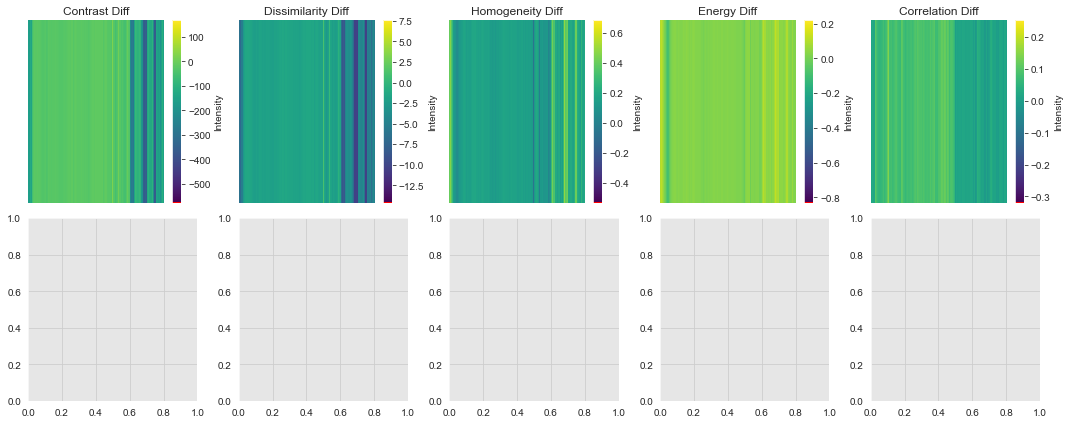

In [181]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Compute the differences between GLCM properties of A and B
contrast_diff = contrast_A - contrast_B
dissimilarity_diff = dissimilarity_A - dissimilarity_B
homogeneity_diff = homogeneity_A - homogeneity_B
energy_diff = energy_A - energy_B
correlation_diff = correlation_A - correlation_B

# Create a custom colormap where zero values are red
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1, 0, 0, 1)  # Red color for zero values
custom_cmap = mcolors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

# Plot the difference images with zero values highlighted in red
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot difference images
cax = axes[0, 0].imshow(contrast_diff.reshape(1, -1), cmap=custom_cmap, aspect='auto', vmin=np.min(contrast_diff), vmax=np.max(contrast_diff))
axes[0, 0].set_title('Contrast Diff')
axes[0, 0].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 0])
cbar.set_label('Intensity')

cax = axes[0, 1].imshow(dissimilarity_diff.reshape(1, -1), cmap=custom_cmap, aspect='auto', vmin=np.min(dissimilarity_diff), vmax=np.max(dissimilarity_diff))
axes[0, 1].set_title('Dissimilarity Diff')
axes[0, 1].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 1])
cbar.set_label('Intensity')

cax = axes[0, 2].imshow(homogeneity_diff.reshape(1, -1), cmap=custom_cmap, aspect='auto', vmin=np.min(homogeneity_diff), vmax=np.max(homogeneity_diff))
axes[0, 2].set_title('Homogeneity Diff')
axes[0, 2].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 2])
cbar.set_label('Intensity')

cax = axes[0, 3].imshow(energy_diff.reshape(1, -1), cmap=custom_cmap, aspect='auto', vmin=np.min(energy_diff), vmax=np.max(energy_diff))
axes[0, 3].set_title('Energy Diff')
axes[0, 3].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 3])
cbar.set_label('Intensity')

cax = axes[0, 4].imshow(correlation_diff.reshape(1, -1), cmap=custom_cmap, aspect='auto', vmin=np.min(correlation_diff), vmax=np.max(correlation_diff))
axes[0, 4].set_title('Correlation Diff')
axes[0, 4].axis('off')

cbar = plt.colorbar(cax, ax=axes[0, 4])
cbar.set_label('Intensity')

plt.tight_layout()
plt.show()


In [145]:
"""
GLCM (Gray-Level Co-occurrence Matrix):

1-  Texture Analysis: 
    GLCM is commonly used for texture analysis in images. 
    In satellite imagery, different land cover types often exhibit distinct textures, which can be captured by GLCM. 
    By computing GLCM features, such as contrast, correlation, energy, and homogeneity, you can characterize the texture properties of different regions in the satellite images.

2-  Spatial Relationships: 
    GLCM captures the spatial relationships between pixel intensities in an image. 
    In satellite imagery, changes in land cover or land use often result in spatially correlated patterns. 
    GLCM can quantify these patterns by analyzing the frequency of occurrence of different pairs of pixel intensities at different spatial offsets. 
    This information can be valuable for distinguishing between different classes in the classification task.

3-  Invariance to Intensity Variations: 
    GLCM features are often invariant to changes in overall image intensity, making them robust to variations in illumination or sensor settings. 
    In satellite imagery, variations in lighting conditions or atmospheric effects can affect the overall brightness of the images. 
    By extracting GLCM features, you can focus on capturing the underlying texture and spatial patterns that are less affected by such variations.
"""
# Calculate GLCM features for training images
X_train_glcm = []
Y_train_glcm = []

for image_A, image_B, label in zip(before_images, after_images, labels):
    # Convert the images to grayscale
    gray_image_A = cv2.cvtColor(image_A, cv2.COLOR_BGR2GRAY)
    gray_image_B = cv2.cvtColor(image_B, cv2.COLOR_BGR2GRAY)
    
    # Calculate the GLCM for the images
    glcm_A = graycomatrix(gray_image_A, [1], [0], 256, symmetric=True, normed=True)
    glcm_B = graycomatrix(gray_image_B, [1], [0], 256, symmetric=True, normed=True)
    
    # Calculate the contrast, dissimilarity, homogeneity, energy, and correlation properties
    contrast_A = graycoprops(glcm_A, 'contrast')
    dissimilarity_A = graycoprops(glcm_A, 'dissimilarity')
    homogeneity_A = graycoprops(glcm_A, 'homogeneity')
    energy_A = graycoprops(glcm_A, 'energy')
    correlation_A = graycoprops(glcm_A, 'correlation')
    
    contrast_B = graycoprops(glcm_B, 'contrast')
    dissimilarity_B = graycoprops(glcm_B, 'dissimilarity')
    homogeneity_B = graycoprops(glcm_B, 'homogeneity')
    energy_B = graycoprops(glcm_B, 'energy')
    correlation_B = graycoprops(glcm_B, 'correlation')
    
    # Take the mean of the GLCM properties
    glcm_mean = np.array([np.mean(contrast_A), np.mean(dissimilarity_A), np.mean(homogeneity_A), np.mean(energy_A), np.mean(correlation_A),
                          np.mean(contrast_B), np.mean(dissimilarity_B), np.mean(homogeneity_B), np.mean(energy_B), np.mean(correlation_B)])
    
    # Append the GLCM features to the list
    X_train_glcm.append(glcm_mean)
    
    # Take the mean of all channels of the label image so that the result is a scalar
    Y_train_glcm.append(np.mean(label))

# Convert lists to NumPy arrays
X_train_glcm = np.array(X_train_glcm)
Y_train_glcm = np.array(Y_train_glcm)


In [146]:
print(X_train_glcm.shape)
print(Y_train_glcm.shape)

(4868, 10)
(4868,)


In [147]:
# convert the y_train_glcm to binary so that it can be used for classification
threshold = 10
Y_train_glcm_binary = (Y_train_glcm > threshold).astype(int)

In [149]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_glcm, Y_train_glcm_binary, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate Jaccard Index for training data and test data
jaccard_train = jaccard_score(y_train, rf_classifier.predict(X_train))
jaccard_test = jaccard_score(y_test, y_pred)

print(f'Jaccard Index (Training): {jaccard_train:.2f}')
print(f'Jaccard Index (Test): {jaccard_test:.2f}')


Accuracy: 0.93
F1 Score: 0.88
Jaccard Index (Training): 0.94
Jaccard Index (Test): 0.78


## LBP

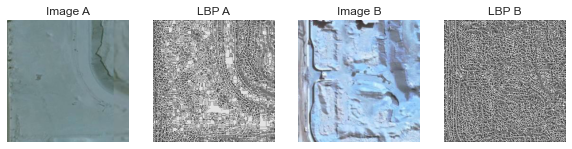

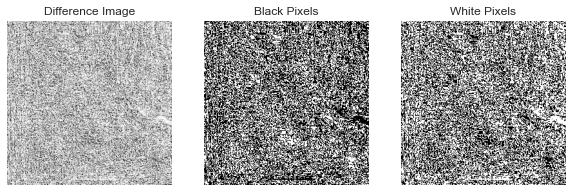

In [186]:
import cv2
from skimage.feature import local_binary_pattern
import numpy as np
import matplotlib.pyplot as plt

# Function to display images
def display_images(images, titles, cmap=None):
    fig, axes = plt.subplots(1, len(images), figsize=(10, 5))
    for ax, image, title in zip(axes, images, titles):
        ax.imshow(image, cmap=cmap)
        ax.set_title(title)
        ax.axis('off')
    plt.show()

# Calculate LBP images for training images
lbp_images_A = []
lbp_images_B = []


before_images2 = before_images[0:1]
after_images2 = after_images[0:1]
 
for image_A, image_B in zip(before_images2, after_images2):
    # Convert the images to grayscale
    gray_image_A = cv2.cvtColor(image_A, cv2.COLOR_BGR2GRAY)
    gray_image_B = cv2.cvtColor(image_B, cv2.COLOR_BGR2GRAY)
    
    # Calculate the LBP for the images
    lbp_A = local_binary_pattern(gray_image_A, P=8, R=1, method='uniform')
    lbp_B = local_binary_pattern(gray_image_B, P=8, R=1, method='uniform')
    
    # Append LBP images to the list
    lbp_images_A.append(lbp_A)
    lbp_images_B.append(lbp_B)

# Display original grayscale images and their corresponding LBP images
for i in range(len(before_images2)):
    display_images([before_images2[i], lbp_images_A[i], after_images2[i], lbp_images_B[i]], 
                   ['Image A', 'LBP A', 'Image B', 'LBP B'], cmap='gray')
    
from sklearn.cluster import KMeans

# Calculate the difference between LBP images of A and B
lbp_diff = np.abs(lbp_images_A[0] - lbp_images_B[0])

# Reshape the difference image for clustering
lbp_diff_flat = lbp_diff.reshape(-1, 1)

# Perform K-means clustering on the difference image
num_clusters = 2  # Clustering into black and white regions
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(lbp_diff_flat)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_.flatten()

# Assign cluster labels to each pixel
cluster_labels = kmeans.labels_

# Reshape cluster labels to the shape of the difference image
cluster_labels = cluster_labels.reshape(lbp_diff.shape)

# Separate pixels into black and white regions based on clustering
black_pixels = np.where(cluster_labels == 0, 255, 0)
white_pixels = np.where(cluster_labels == 1, 255, 0)

# invert the difference image
lbp_diff = 255 - lbp_diff

# Display the clustered regions
display_images([lbp_diff, black_pixels, white_pixels], ['Difference Image', 'Black Pixels', 'White Pixels'], cmap='gray')



In [190]:
# Calculate LBP features for training images
X_train_lbp = []
Y_train_lbp = []

# Define a function to perform K-means clustering and separate black and white pixels
def cluster_lbp_difference(lbp_A, lbp_B):
    # Calculate the difference between LBP images of A and B
    lbp_diff = np.abs(lbp_A - lbp_B)

    # Reshape the difference image for clustering
    lbp_diff_flat = lbp_diff.reshape(-1, 1)

    # Perform K-means clustering on the difference image
    num_clusters = 2  # Clustering into black and white regions
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(lbp_diff_flat)

    # Get cluster centers
    cluster_centers = kmeans.cluster_centers_.flatten()

    # Assign cluster labels to each pixel
    cluster_labels = kmeans.labels_

    # Reshape cluster labels to the shape of the difference image
    cluster_labels = cluster_labels.reshape(lbp_diff.shape)

    # Separate pixels into black and white regions based on clustering
    black_pixels = np.where(cluster_labels == 0, 255, 0)
    white_pixels = np.where(cluster_labels == 1, 255, 0)

    return black_pixels, white_pixels

# Initialize lists to store clustered LBP differences
black_pixels_list = []
white_pixels_list = []

# Initialize lists to store differences between black and white pixels
diff_pixels = []

# Calculate LBP features for training images and perform clustering
for image_A, image_B, label in zip(before_images, after_images, labels):
    # Convert the images to grayscale
    gray_image_A = cv2.cvtColor(image_A, cv2.COLOR_BGR2GRAY)
    gray_image_B = cv2.cvtColor(image_B, cv2.COLOR_BGR2GRAY)
    
    # Calculate the LBP for the images
    lbp_A = local_binary_pattern(gray_image_A, P=8, R=1, method='uniform')
    lbp_B = local_binary_pattern(gray_image_B, P=8, R=1, method='uniform')
    
    # Perform clustering on LBP difference
    black_pixels, white_pixels = cluster_lbp_difference(lbp_A, lbp_B)
    
    # Calculate the difference between black and white pixels
    diff = black_pixels - white_pixels
    
    # Flatten the difference and append it to the list
    diff_pixels.append(diff.flatten())
    
    # Append label to Y_train_lbp
    Y_train_lbp.append(label)

# Convert the list of differences to a numpy array
X_train_lbp = np.array(diff_pixels)

# Convert Y_train_lbp to a numpy array
Y_train_lbp = np.array(Y_train_lbp)


In [191]:
print(X_train_lbp.shape)
print(Y_train_lbp.shape)

(4868, 65536)
(4868,)


In [192]:
# convert the y_train_lbp to binary so that it can be used for classification
threshold = 5
Y_train_lbp_binary = (Y_train_lbp > threshold).astype(int)


In [193]:
print(Y_train_lbp_binary[:10])

[0 0 0 0 0 0 0 0 0 0]


In [195]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_lbp, Y_train_lbp_binary, test_size=0.2, random_state=42)

# Train a Random Forest classifier 
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'F1 Score: {f1:.2f}')

# Calculate Jaccard Index
jaccard_index = jaccard_score(y_test, y_pred)

print(f'Jaccard Index: {jaccard_index}')

F1 Score: 0.00
Jaccard Index: 0.0


c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Histogram Difference + HOG + GLCM + LBP

In [211]:
print(X_train_hist_diff.shape)
print(X_train_clustered_hog.shape)
print(X_train_glcm.shape)

(4868, 3)
(4868, 5)
(4868, 10)


In [217]:
# try combining all features
X_train_all = np.concatenate((X_train_hist_diff, X_train_clustered_hog, X_train_glcm), axis=1)
print(X_train_all.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_all, Y_train_hog_binary, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate Jaccard Index for training data and test data
jaccard_train = jaccard_score(y_train, rf_classifier.predict(X_train))
jaccard_test = jaccard_score(y_test, y_pred)

print(f'Jaccard Index (Training): {jaccard_train:.2f}')
print(f'Jaccard Index (Test): {jaccard_test:.2f}')



(4868, 18)
Accuracy: 0.94
F1 Score: 0.89
Jaccard Index (Training): 0.94
Jaccard Index (Test): 0.80


In [221]:
# Select features
selected_features = [X_train_glcm, X_train_clustered_hog]

# Concatenate selected features
X_train_selected = np.concatenate(selected_features, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_selected, Y_train_glcm_binary, test_size=0.2, random_state=42)

# Initialize and train the RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
jaccard_index = jaccard_score(y_test, y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'Jaccard Index: {jaccard_index:.2f}')


Accuracy: 0.93
F1 Score: 0.87
Jaccard Index: 0.77


In [67]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with RandomForestClassifier and parameter grid
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='jaccard', verbose=1, n_jobs=-1)

# Perform grid search on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding Jaccard Index
best_params = grid_search.best_params_
best_jaccard = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Jaccard Index:", best_jaccard)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 150}
Best Jaccard Index: 0.7798587388211577


## PCA

In [223]:
# Perform PCA on the training data
pca = PCA(n_components=5)
X_train_pca = pca.fit_transform(X_train_all)

print(X_train_pca.shape)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_pca, Y_train_hog_binary, test_size=0.2, random_state=42)

# Train a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'F1 Score: {f1:.2f}')

# Calculate Jaccard Index
jaccard_index = jaccard_score(y_test, y_pred)

print(f'Jaccard Index: {jaccard_index}')


(4868, 5)


Accuracy: 0.75
F1 Score: 0.49
Jaccard Index: 0.3287292817679558
